In [47]:
# Importing Libraries

import numpy as np
from matplotlib import pyplot   

# Testing update

#  hello there
# Hi this is gray updating the documenthshshshshsh

In [48]:
# Given Variables
Ma  = 0.2
Re  = 10

# Input Parameters

# x-direction variables 

Nx                  = 100               # Number of Nodes
x_start             = 0.0               # Physical start location
x_end               = 2*np.pi           # Physical end location

# y-direction variables

Ny                  = 100               # Number of Nodes
y_start             = 0.0               # Physical start location
y_end               = 2*np.pi           # Physical end location

# Other variables
             
order_of_derivative = 2                 # Derivative order
dim                 = 2                 # Two-Dimensional Space

# Air Fluid properties

R_u                 = 8.31446261815324      # Universal Gas Constant J/(mol * K)
m_air               = 28.97 / 1000          # Molar Mass of Air
gamma               = 7.0 / 5.0             # Standard Conditions of Air
R_s_A               = R_u / m_air           # Specific gas contant for air
C_v_A               = R_s_A / (gamma - 1.0)    
C_p_A               = R_s_A + C_v_A           
Pr                  = 0.71                  # Constant for both speicies

# Nitrogen Fluid Properties

m_nitrogen          = 28.02 / 1000
R_s_N               = R_u / m_nitrogen
C_v_N               = R_s_N / (gamma-1.0)
C_p_N               = R_s_N + C_v_N

# May average the Rs??

R_s                 = (R_s_N+R_s_A) / 2.0  #IDK


# Mass fraction

Y_N                 = m_nitrogen / (m_nitrogen+m_air)
Y_A                 = 1.0 - Y_N

# Time varaibles

cfl                 = 0.4               # CFL number
t_end               = 1                 # End time
iter_end            = 100000            # Stop condition (may remove)

# Initial Conditions

p_0                 = 100000
T_0                 = 300
L                   = 2* np.pi

# For air
c_0_A               = np.sqrt(gamma*R_s_A*T_0)            # I averaged Rs for this but changed it so IDK
v_0_A               = Ma * c_0_A
c_0_N               = np.sqrt(gamma*R_s_N *T_0)           
v_0_N               = Ma * c_0_N
# Avergaged
c_0 = Y_A * c_0_A + Y_N * c_0_N
v_0 = Y_A * v_0_A + Y_N * v_0_N
print(v_0)
print(c_0)

# Adding multiple rhos
rho_0_A               = p_0 / (R_s_A * T_0)             # We may need to add two different rho_0; i.e one for each speicies
mu_A                  = (rho_0_A * v_0_A * L) / Re
rho_0_N               = p_0 / (R_s_N * T_0)             
mu_N                  = (rho_0_N * v_0_N * L) / Re

# Averaged
rho_0 = Y_A * rho_0_A + Y_N * rho_0_N

# Kappa values
kappa_A               = mu_A * C_p_A / Pr
kappa_N               = mu_N * C_p_N / Pr


# Mixing rules for RTI??

C_p = Y_N * C_p_N + Y_A * C_p_A
C_v = Y_N * C_v_N + Y_A * C_v_A
mu = (mu_N * Y_N / m_nitrogen**0.5) / (Y_N / m_nitrogen**0.5) + (mu_A * Y_A / m_air**0.5) / (Y_A / m_air**0.5) # Why did they not just do mu_N + mu_A
kappa = mu = (kappa_N * Y_N / m_nitrogen**0.5) / (Y_N / m_nitrogen**0.5) + (kappa_A * Y_A / m_air**0.5) / (Y_A / m_air**0.5)

# v_0                 = 1.0           # Initial Velocity
# T_0                 = 300           # Initial Temperature
# rho_0               = 1.0           # Initial Density
# L                   = 1.0           # Legnth


70.01197293137349
350.0598646568675


In [49]:
# Parameters that can be calculated by input parameters

# Statment for Number of ghost cell required per boundary

if(order_of_derivative == 2):
    ngc = 1                     

elif(order_of_derivative == 4):
    ngc = 2  
    
elif(order_of_derivative == 6):
    ngc = 3

# x-direction parameters

dx      = (x_end - x_start) / (Nx)                                                   # Mesh Resolution
x       = np.linspace(x_start + dx/2 - ngc*dx, x_end - dx/2 + ngc*dx, Nx + 2*ngc)    # Generate array from 0 to 2pi with 100 nodes

# y-direction parameters

dy      = (y_end - y_start) / (Ny)                                                    # Mesh resolution
y       = np.linspace(y_start + dy/2 - ngc*dy, y_end - dy/2 + ngc*dy, Ny + 2*ngc)     # Generate array from 0 to 2pi with 100 nodes


V         = np.zeros((Nx+2*ngc, Ny+2*ngc, dim+3))                                       # 2 density + 2 dimension of velocity + energy
Q         = np.zeros((Nx+2*ngc, Ny+2*ngc, dim+3))                                       # 2 density + 2 dimension of momentum + energy
T         = np.zeros((Nx+2*ngc, Ny+2*ngc))                                              # May need to change
P         = np.zeros((Nx+2*ngc, Ny+2*ngc))
# Mesh Generation

X,Y = np.meshgrid(x,y)


In [50]:
# Fill Ghost Cell function

def fill_gc_2D(V,ngc):
    V [:ngc,ngc:-ngc]     = V[-2*ngc:-ngc, ngc:-ngc]   # Fill the left ghost cell with the right data cell
    V [-ngc:,ngc:-ngc]    = V[ngc   :2*ngc,ngc:-ngc]   # Fill the right ghost cell with the left data cell
    V [ngc:-ngc,:ngc]     = V[ngc:-ngc, -2*ngc:-ngc]   # Fill the left ghost cell with the top data cell
    V [ngc:-ngc,-ngc:]    = V[ngc:-ngc, ngc  :2*ngc]   # Fill the right ghost cell with the bottom data cell
    
    # Fill corners
    V [-ngc:,-ngc:]     = V[ngc:2*ngc,ngc:2*ngc]        # Fill the right-top ghost cell
    V [:ngc,-ngc:]      = V[-2*ngc:-ngc,ngc:2*ngc]      # Fill the left-top ghost cell
    V [-ngc:,:ngc]      = V[ngc:2*ngc,-2*ngc:-ngc]      # Fill the right-bottom ghost cell
    V [:ngc,:ngc]       = V[-2*ngc:-ngc,-2*ngc:-ngc]    # Fill the left-bottom ghost cell

    return(V)

In [51]:
# Intial condtions set up
def initial_condition_TGV(V,v_0,p_0,rho_0,T_0,C_v,Nx,Ny,x,y,ngc):
    for i in range(Nx):
        for j in range(Ny):
            V[ngc+i, ngc+j, 0] =  rho_0_A
            V[ngc+i, ngc+j, 0] =  rho_0_N
            V[ngc+i, ngc+j, 2] =  v_0*np.sin(x[ngc+i])*np.cos(y[ngc+j])
            V[ngc+i, ngc+j, 3] = -v_0*np.cos(x[ngc+i])*np.sin(y[ngc+j])
            V[ngc+i, ngc+j, 4] =  rho_0*(C_v*T_0 + 0.5*(V[ngc+i, ngc+j, 1]*V[ngc+i, ngc+j, 1] + V[ngc+i, ngc+j, 2]*V[ngc+i, ngc+j, 2]))
            P[ngc+i, ngc+j]    =  p_0 + (np.cos(2*x[ngc+i]) + np.cos(2*y[ngc+j]))*(rho_0/16.0)
            T[ngc+i, ngc+j]    =  T_0
    return V, P, T


In [52]:
# Variables from Ideal Gas Law
# Just make sure to give the function V[:,:,0] for rho
def pressure_from_ideal_gas_law(rho,R_s,T,ngc):
    #P                   = np.zeros((Nx+2*ngc, Ny+2*ngc))
    P[:,:]                                   = rho*R_s*T[:,:]
    #P                                   = fill_gc_2D(P,ngc)

    return(P)

# def temperature_from_ideal_gas_law(rho,R_s,P,ngc):
#     #T                   = np.zeros((Nx+2*ngc, Ny+2*ngc))
#     T[ngc:-ngc,ngc:-ngc]                = P[ngc:-ngc,ngc:-ngc]/(R_s*rho[ngc:-ngc,ngc:-ngc])
#     T                                   = fill_gc_2D(T,ngc)

#     return(T)

# def density_from_ideal_gas_law(T,R_s,P,ngc):

#     rho[ngc:-ngc,ngc:-ngc]                = P[ngc:-ngc,ngc:-ngc]/(R_s*T[ngc:-ngc,ngc:-ngc])
#     rho                                   = fill_gc_2D(rho,ngc)

#     return(rho)



In [53]:

# Variables from internal Engergy

# def pressure_from_internal_energy(P,e,gamma,rho):
    
#     P[ngc:-ngc,ngc:-ngc]                  = (gamma-1) * rho[ngc:-ngc,ngc:-ngc] * e[ngc:-ngc,ngc:-ngc]
#     P                                     = fill_gc_2D(P,ngc)
#     return(P)

# def internal_energy_from_temperature(e,C_v,T):
    
#     e[ngc:-ngc,ngc:-ngc]                  = C_v * T[ngc:-ngc,ngc:-ngc]  
#     e                                     = fill_gc_2D(e,ngc)
#     return(e)

# Based on denis code
def calculate_T_from_e(e, C_v):
    T                    = e / C_v
    #T                    = fill_gc_2D(T,ngc)
    return(T)



In [54]:
# Time Step function

def time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T):
    u_mag     = np.sqrt(V[ngc:-ngc,ngc:-ngc,1]*V[ngc:-ngc,ngc:-ngc,1] + V[ngc:-ngc,ngc:-ngc,2]*V[ngc:-ngc,ngc:-ngc,2])
    c_0       = np.sqrt(gamma*R_s*T[ngc:-ngc,ngc:-ngc])
    u_mag    += c_0
    dt_adv    = min(cfl * dx / (np.max(np.amax(u_mag)) ), cfl * dy / np.max(np.amax(u_mag)))
    nu        = mu/V[ngc:-ngc,ngc:-ngc,0]
    dt_diff   = min(cfl * (dx*dx) / (np.max(np.amax(nu)) ), cfl * (dy*dy) / np.max(np.amax(nu)))
    dt        = min(dt_adv,dt_diff)
    return(dt)

In [55]:
# Derivatives

# Initialize df_dx_2D

df_dx_2D      = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
df_dy_2D      = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
d2f_dx2_2D    = np.zeros((Nx + 2*ngc, Ny + 2*ngc))
d2f_dy2_2D    = np.zeros((Nx + 2*ngc, Ny + 2*ngc))

def df_dx_second_order_centered_2D(V,dx,ngc):
    
    df_dx_2D[ngc:-ngc,ngc:-ngc]   = (V[ngc+1:,ngc:-ngc] - V[ngc-1:-ngc-1,ngc:-ngc]) / (2*dx)                                            
    
    return(df_dx_2D)

# Initialize df_dy_2D



def df_dy_second_order_centered_2D(V,dy,ngc):
    
    df_dy_2D[ngc:-ngc,ngc:-ngc]   = (V[ngc:-ngc,ngc+1:] - V[ngc:-ngc,ngc-1:-ngc-1]) / (2*dy)  
    
    return(df_dy_2D)


# Second Derivative Second Order Functions

# Initialize d2f_dx2_2D



def non_conservative_d2f_dx2_second_order_centered_2D(V,dx,ngc):                                                     
    d2f_dx2_2D[ngc:-ngc,ngc:-ngc]            = (V[ngc+1:,ngc:-ngc] - 2*V[ngc:-ngc,ngc:-ngc] + V[ngc-1:-ngc-1,ngc:-ngc]) / (dx**2)                                           
    return(d2f_dx2_2D)


# Initialize d2f_dy2_2D


def non_conservative_d2f_dy2_second_order_centered_2D(V,dy,ngc):                                                     
    d2f_dy2_2D[ngc:-ngc,ngc:-ngc]            = (V[ngc:-ngc,ngc+1:] - 2*V[ngc:-ngc,ngc:-ngc] + V[ngc:-ngc,ngc-1:-ngc-1]) / (dy**2)                                            
    return(d2f_dy2_2D)

In [56]:
# Calculating Tau's
def calculate_tau(u,v,dx,dy,mu):
    tau_xx = (2.0/3.0)*mu*(2*df_dx_second_order_centered_2D(u,dx,ngc) - df_dy_second_order_centered_2D(v,dy,ngc))
    tau_yy = (2.0/3.0)*mu*(2*df_dy_second_order_centered_2D(v,dy,ngc) - df_dx_second_order_centered_2D(u,dx,ngc))
    tau_xy = mu*(df_dy_second_order_centered_2D(u,dy,ngc) + df_dx_second_order_centered_2D(v,dx,ngc))
    tau_xx = fill_gc_2D(tau_xx,ngc)
    tau_yy = fill_gc_2D(tau_yy,ngc)
    tau_xy = fill_gc_2D(tau_xy,ngc)
    return(tau_xx,tau_yy,tau_xy)

def get_Q_from_V(V,Q):
    Q[:,:,0] = V[:,:,0]
    Q[:,:,1] = V[:,:,0]*V[:,:,1]
    Q[:,:,2] = V[:,:,0]*V[:,:,2]
    Q[:,:,3] = V[:,:,3]
    return(Q)

def get_V_from_Q(Q,V):
    V[:,:,0] = Q[:,:,0]
    V[:,:,1] = Q[:,:,1]/Q[:,:,0]
    V[:,:,2] = Q[:,:,2]/Q[:,:,0]
    V[:,:,3] = Q[:,:,3]
    return(V)

In [ ]:
# Main code



# Old Code
    
V, P, T = initial_condition_TGV(V,v_0,p_0,rho_0,T_0,C_v,Nx,Ny,x,y,ngc)

# Fill ghost cells on intial conditions
V[:,:,0] = fill_gc_2D(V[:,:,0],ngc)         # Air Density
V[:,:,1] = fill_gc_2D(V[:,:,1],ngc)         # Air Density
V[:,:,2] = fill_gc_2D(V[:,:,2],ngc)         # x-direction Velocity
V[:,:,3] = fill_gc_2D(V[:,:,3],ngc)         # y-direction Velocity
V[:,:,4] = fill_gc_2D(V[:,:,4],ngc)         # Energy
P        = fill_gc_2D(P[:,:],ngc)           # Pressure
T        = fill_gc_2D(T[:,:],ngc)           # Temperature

Q        = get_Q_from_V(V,Q)

# Create initial time step

dt   = time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T)

# Take derivatives


# Initalization

#import time
current_time                = 0.0
iter                        = 0
flag                        = False

# Plot Times

plot_times                  = [0,0.01,0.02]         
next_plot_time              = plot_times.pop(0)
t                           = []
ke                          = []
enstrophy                   = []  
ke2                         = []
while(current_time < t_end):    
    if((current_time+dt) > next_plot_time):                 # Statement to make sure that the plot time is the same as the current time
        dt                  = next_plot_time - current_time
        flag                = True                               
    # Time counter
    t.append(current_time)
    # Kinetic energy
    # kinetic  = (np.mean(V[ngc:-ngc,ngc:-ngc,0]* 0.5 * (V[ngc:-ngc,ngc:-ngc,1] * V[ngc:-ngc,ngc:-ngc,1] + V[ngc:-ngc,ngc:-ngc,2] * V[ngc:-ngc,ngc:-ngc,2])))
    # ke.append(kinetic)
    
   
    # Enstrophy
    enstrophy.append(np.mean((df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc]) * (df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc])))
    #T = P / (V[:,:,0]*R_s)
    # Calculate P and T
    #Top one worked
    e    = (Q[:,:,3] / V[:,:,0]  - 0.5 * (V[:,:,1] * V[:,:,1] + V[:,:,2] * V[:,:,2])) 
    #e    = P / ((gamma-1)*V[:,:,0])
    #e    = C_v*T
    #e     = V[:,:,0] * R_s * 
    T    = calculate_T_from_e(e, C_v)
    P    = pressure_from_ideal_gas_law(V[:,:,0],R_s,T[:,:],ngc)



    #e    = P / ((gamma-1)*V[:,:,0])

    # Kinetic Energy using E
    # Both Match

    #kinetic  = (np.mean(V[ngc:-ngc,ngc:-ngc,3] - V[ngc:-ngc,ngc:-ngc,0] * e[ngc:-ngc,ngc:-ngc] ))
    kinetic  = (np.mean(V[ngc:-ngc,ngc:-ngc,3] - V[ngc:-ngc,ngc:-ngc,0] * C_v*T[ngc:-ngc,ngc:-ngc] ))
    ke.append(kinetic)

    # Kinetic Energy using Velocity
    kinetic2  = (np.mean(V[ngc:-ngc,ngc:-ngc,0]* 0.5 * (V[ngc:-ngc,ngc:-ngc,1] * V[ngc:-ngc,ngc:-ngc,1] + V[ngc:-ngc,ngc:-ngc,2] * V[ngc:-ngc,ngc:-ngc,2])))
    ke2.append(kinetic2)

    # Calculate Tau's
    tau_xx, tau_yy, tau_xy = calculate_tau(V[:,:,1],V[:,:,2],dx,dy,mu)

    # Continuity for air

    Q[:,:,0] += -((df_dx_second_order_centered_2D(V[:,:,0]*V[:,:,1]*Y_A,dx,ngc) + df_dy_second_order_centered_2D(V[:,:,0]*V[:,:,2] * Y_A ,dy,ngc)) 
                    + df_dx_second_order_centered_2D(V[:,:,0]* (df_dx_second_order_centered_2D(Y_A,dx,ngc) +df_dy_second_order_centered_2D(Y_A,dy,ngc)),dx,ngc)
                    + df_dy_second_order_centered_2D(V[:,:,0]* (df_dx_second_order_centered_2D(Y_A,dx,ngc) +df_dy_second_order_centered_2D(Y_A,dy,ngc)),dy,ngc))* dt
    # Continuity for nitrogen

    Q[:,:,1] += -((df_dx_second_order_centered_2D(V[:,:,0]*V[:,:,1]*Y_N,dx,ngc) + df_dy_second_order_centered_2D(V[:,:,0]*V[:,:,2] * Y_N ,dy,ngc)) 
                    + df_dx_second_order_centered_2D(V[:,:,0]* (df_dx_second_order_centered_2D(Y_N,dx,ngc) +df_dy_second_order_centered_2D(Y_N,dy,ngc)),dx,ngc)
                    + df_dy_second_order_centered_2D(V[:,:,0]* (df_dx_second_order_centered_2D(Y_N,dx,ngc) +df_dy_second_order_centered_2D(Y_N,dy,ngc)),dy,ngc))* dt

    #Q[:,:,0] += -(df_dx_second_order_centered_2D(V[:,:,1],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,2],dy,ngc))* dt
    
    # rho*u
    Q[:,:,2] += (-(df_dx_second_order_centered_2D(Q[:,:,1]*V[:,:,1] + P[:,:],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,1]*V[:,:,2],dy,ngc))+df_dx_second_order_centered_2D(tau_xx,dx,ngc) + df_dy_second_order_centered_2D(tau_xy,dy,ngc))*dt
    
    # rho*V
    Q[:,:,3] += (-(df_dx_second_order_centered_2D(Q[:,:,1]*V[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,2]*V[:,:,2]+P[:,:],dy,ngc))+df_dx_second_order_centered_2D(tau_xy,dx,ngc) + df_dy_second_order_centered_2D(tau_yy,dy,ngc))*dt
    
    # Wrote two energy equations to validate my code
    # Q[:,:,3] += (-(df_dx_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,1],dx,ngc) + df_dy_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,2],dy,ngc)) 
    #              + non_conservative_d2f_dx2_second_order_centered_2D(tau_xx*V[:,:,1]+tau_xy*V[:,:,2],dx,ngc) + non_conservative_d2f_dy2_second_order_centered_2D(tau_xy*V[:,:,1]+tau_yy*V[:,:,2],dx,ngc) 
    #              + kappa * (non_conservative_d2f_dx2_second_order_centered_2D(T[:,:],dx,ngc) + non_conservative_d2f_dy2_second_order_centered_2D(T[:,:],dy,ngc)))*dt

    # Energy
    Q[:,:,4] += (-df_dx_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,1],dx,ngc) - df_dy_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,2],dy,ngc)
    + df_dx_second_order_centered_2D(tau_xx*V[:,:,1]+tau_xy*V[:,:,2] + kappa * df_dx_second_order_centered_2D(T[:,:],dx,ngc),dx,ngc) 
    + df_dy_second_order_centered_2D(tau_xy*V[:,:,1]+tau_yy*V[:,:,2]+ kappa * df_dy_second_order_centered_2D(T[:,:],dy,ngc),dy,ngc))*dt

    # We need to add qd_1 = h_1 * j_1 = cp_1 * T * -rho* D_1 * grad Y_i


    Q[:,:,0] = fill_gc_2D(Q[:,:,0],ngc)
    Q[:,:,1] = fill_gc_2D(Q[:,:,1],ngc)
    Q[:,:,2] = fill_gc_2D(Q[:,:,2],ngc)
    Q[:,:,3] = fill_gc_2D(Q[:,:,3],ngc)

    V        = get_V_from_Q(Q,V)
    
    current_time            += dt
    dt                      = time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T) 
    
    
    iter        += 1
    
    if (flag == True):          #Statement to plot when the current _time == next_plot_time
        print(current_time)
        pyplot.figure(figsize=(8,5))
        vorticity           = df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc]
        contour             = pyplot.contourf(X[ngc:-ngc,ngc:-ngc], Y[ngc:-ngc,ngc:-ngc], vorticity, cmap = "jet",levels=np.linspace(-200,200,30)) # Used Chatgpt for levels
        cbar                = pyplot.colorbar(contour) # Used Chatgpt for colorbar
        cbar.set_ticks(np.linspace(-200,200,9))  # Used Chatgpt for colorbar ticks
        cbar.set_label("Vorticity  (1/s)")        # Used Chatgpt for colorbar label
        pyplot.xlim(0,2*np.pi)
        pyplot.xticks(np.linspace(0,2*np.pi,9),[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
                  r"$\frac{5\pi}{4}$", r"$\frac{3\pi}{2}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]) 
        pyplot.ylim(0,2*np.pi)
        pyplot.yticks(np.linspace(0,2*np.pi,9),[r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$", 
                  r"$\frac{5\pi}{4}$", r"$\frac{3\pi}{2}$", r"$\frac{7\pi}{4}$", r"$2\pi$"]) 
        pyplot.xlabel(r"x  [$0, 2\pi$]")
        pyplot.ylabel(r"y  [$0, 2\pi$]")
        pyplot.show()
        if plot_times:  #Statement to change next_plot_time and reset flag 
            next_plot_time  = plot_times.pop(0)                                
            flag            = False
        if next_plot_time == 0.02 and flag == True:
            pyplot.figure(figsize=(8,5))
            pyplot.plot(t, ke) # Used Chatgpt for levels
            pyplot.xlabel("Time (s)")
            pyplot.ylabel("Average Kinetic Energy (kg/(m*s$^2$))")
            pyplot.show()
            pyplot.figure(figsize=(8,5))
            pyplot.plot(t, ke2) # Used Chatgpt for levels
            pyplot.xlabel("Time (s)")
            pyplot.ylabel("Average Kinetic Energy (kg/(m*s$^2$))")
            pyplot.show()
            pyplot.figure(figsize=(8,5))
            pyplot.plot(t, enstrophy) # Used Chatgpt for levels
            pyplot.xlabel("Time (s)")
            pyplot.ylabel("Average Enstrophy (m$^2$/s$^2$)")
            pyplot.show()
            break
    


NameError: name 'Q_A' is not defined

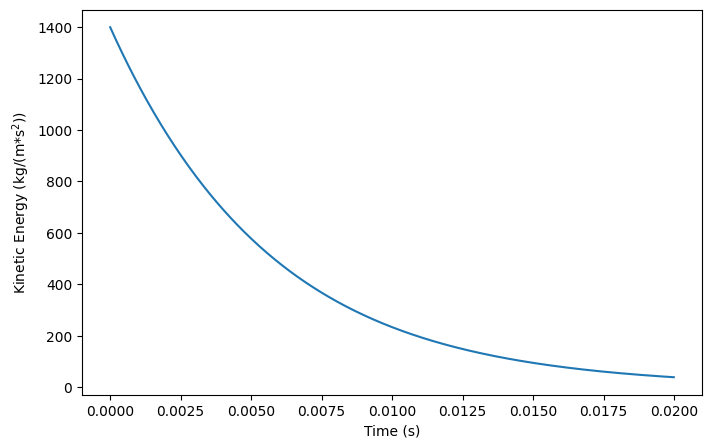

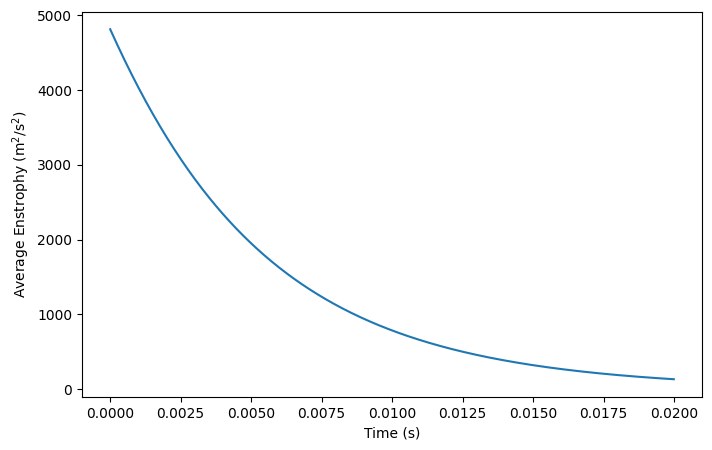

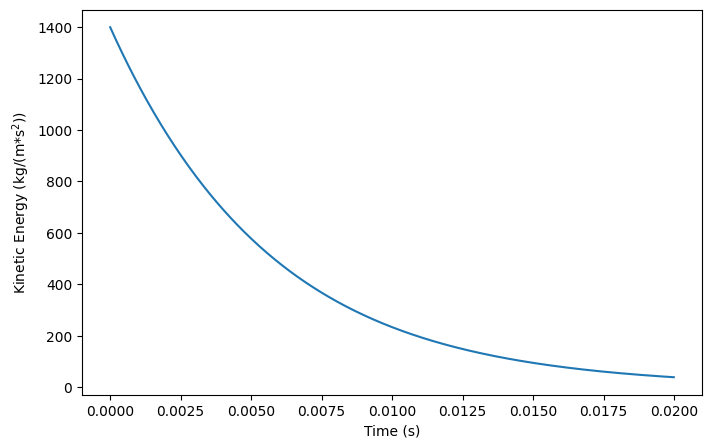

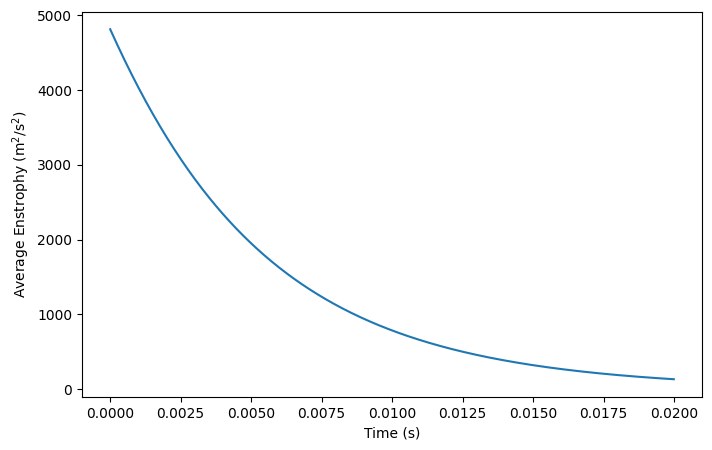

In [ ]:
# Main code

# Old Code
    
V, P, T = initial_condition_TGV(V,v_0,p_0,rho_0,T_0,C_v,Nx,Ny,x,y,ngc)

# Fill ghost cells on intial conditions
V[:,:,0] = fill_gc_2D(V[:,:,0],ngc)         # Density
V[:,:,1] = fill_gc_2D(V[:,:,1],ngc)         # x-direction Velocity
V[:,:,2] = fill_gc_2D(V[:,:,2],ngc)         # y-direction Velocity
V[:,:,3] = fill_gc_2D(V[:,:,3],ngc)         # Energy
P        = fill_gc_2D(P[:,:],ngc)           # Pressure
T        = fill_gc_2D(T[:,:],ngc)           # Temperature

Q        = get_Q_from_V(V,Q)

# Create initial time step

dt   = time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T)

# Take derivatives


# Initalization

#import time
current_time                = 0.0
iter                        = 0
flag                        = False

# Plot Times

plot_times                  = [0.02]         
next_plot_time              = plot_times.pop(0)  
t                           = []
ke                          = []
enstrophy                   = []
while(current_time < t_end):    
    if((current_time+dt) > next_plot_time):                 # Statement to make sure that the plot time is the same as the current time
        dt                  = next_plot_time - current_time
        flag                = True                               
    t.append(current_time)
    # Kinetic energy
    kinetic  = (np.mean(V[:,:,0]* 0.5 * (V[:,:,1] * V[:,:,1] + V[:,:,2] * V[:,:,2])))
    ke.append(kinetic)
    
    # Enstrophy
    enstrophy.append(np.mean((df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc]) * (df_dy_second_order_centered_2D(V[:,:,1],dy,ngc)[ngc:-ngc,ngc:-ngc] - df_dx_second_order_centered_2D(V[:,:,2],dx,ngc)[ngc:-ngc,ngc:-ngc])))
  
    # Calculate P and T
    e    = P / ((gamma-1)*V[:,:,0]) 
    T    = calculate_T_from_e(e, C_v)
    P    = pressure_from_ideal_gas_law(V[:,:,0],R_s,T[:,:],ngc)

    # Calculate Tau's
    tau_xx, tau_yy, tau_xy = calculate_tau(V[:,:,1],V[:,:,2],dx,dy,mu)
    

    Q[:,:,0] += -(df_dx_second_order_centered_2D(Q[:,:,1],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,2],dy,ngc))* dt
    
    Q[:,:,1] += (-(df_dx_second_order_centered_2D(Q[:,:,1]*V[:,:,1],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,1]*V[:,:,2],dy,ngc)+df_dx_second_order_centered_2D(P[:,:],dx,ngc))+df_dx_second_order_centered_2D(tau_xx,dx,ngc) + df_dy_second_order_centered_2D(tau_xy,dy,ngc))*dt
    
    Q[:,:,2] += (-(df_dx_second_order_centered_2D(Q[:,:,1]*V[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(Q[:,:,2]*V[:,:,2],dy,ngc)+df_dx_second_order_centered_2D(P[:,:],dx,ngc))+df_dx_second_order_centered_2D(tau_xy,dx,ngc) + df_dy_second_order_centered_2D(tau_yy,dy,ngc))*dt

    Q[:,:,3] += (-(df_dx_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,1],dx,ngc) + df_dy_second_order_centered_2D((Q[:,:,3]+P[:,:])*V[:,:,2],dy,ngc)) 
                 + df_dx_second_order_centered_2D(tau_xx*V[:,:,1]+tau_xy*V[:,:,2],dx,ngc) + df_dy_second_order_centered_2D(tau_xy*V[:,:,1]+tau_yy*V[:,:,2],dx,ngc) 
                 + kappa * (non_conservative_d2f_dx2_second_order_centered_2D(T[:,:],dx,ngc) + non_conservative_d2f_dy2_second_order_centered_2D(T[:,:],dy,ngc)))*dt

    Q[:,:,0] = fill_gc_2D(Q[:,:,0],ngc)
    Q[:,:,1] = fill_gc_2D(Q[:,:,1],ngc)
    Q[:,:,2] = fill_gc_2D(Q[:,:,2],ngc)
    Q[:,:,3] = fill_gc_2D(Q[:,:,3],ngc)

    V        = get_V_from_Q(Q,V)
    current_time            += dt
    dt                      = time_step_2D(V,dx,dy,mu,cfl,R_s,gamma,T) 
    
    #print(current_time)
    iter        += 1
    
    if (flag == True):          #Statement to plot when the current _time == next_plot_time
        pyplot.figure(figsize=(8,5))
        pyplot.plot(t, ke) # Used Chatgpt for levels
        pyplot.xlabel("Time (s)")
        pyplot.ylabel("Kinetic Energy (kg/(m*s$^2$))")
        pyplot.show()
        pyplot.figure(figsize=(8,5))
        pyplot.plot(t, enstrophy) # Used Chatgpt for levels
        pyplot.xlabel("Time (s)")
        pyplot.ylabel("Average Enstrophy (m$^2$/s$^2$)")
        pyplot.show()
        if plot_times:  #Statement to change next_plot_time and reset flag 
            next_plot_time  = plot_times.pop(0)                                
            flag            = False
        if next_plot_time == 0.02 and flag == True:
            pyplot.figure(figsize=(8,5))
            pyplot.plot(t, ke) # Used Chatgpt for levels
            pyplot.xlabel("Time (s)")
            pyplot.ylabel("Kinetic Energy (kg/(m*s$^2$))")
            pyplot.show()
            pyplot.figure(figsize=(8,5))
            pyplot.plot(t, enstrophy) # Used Chatgpt for levels
            pyplot.xlabel("Time (s)")
            pyplot.ylabel("Average Enstrophy (m$^2$/s$^2$)")
            pyplot.show()
            break
    
